# Low-Dimensional Representation Using Autoencoder

## Getting the Data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

In [2]:
import urllib
file_url = 'https://datasync.ed.ac.uk/public.php/webdav'

password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
password_mgr.add_password(None, file_url, "GbnXJ5bU3m9JPau", "HS2")
handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
opener = urllib.request.build_opener(handler)
opener.open(file_url)
urllib.request.install_opener(opener)
with urllib.request.urlopen(file_url) as response, open('visapy_data.npy', 'wb') as out_file:
    data = response.read()
    out_file.write(data)

# raw data location
data_path = 'visapy_data.npy'

In [3]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 12
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [4]:
Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


## Detecting Spikes

In [5]:
H.DetectFromRaw()

# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 750

In [7]:
H.LoadDetected()

Detected and read 48009 spikes.


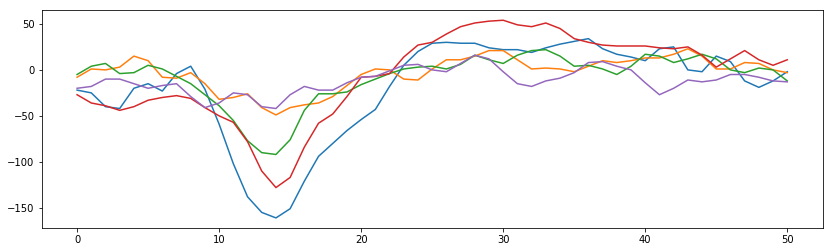

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [14, 18, 77, 90, 156]:
    plt.plot(H.spikes['Shape'][i])
plt.show()
    

In [10]:
length = H.spikes['Shape'][0].shape[0]
np.random.seed(5132)
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(48009, 51)


## Designing the AutoEncoder 

In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(0)

In [85]:
class autoencoder(nn.Module):
    def __init__(self, input_size):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_size, 512),
                                     nn.ELU(),
                                     nn.Linear(512, 256),
                                     nn.ELU(),
                                     nn.Linear(256, 128),
                                     nn.ELU(),
                                     nn.Dropout(p=0.1),
                                     nn.Linear(128, 64),
                                     nn.ELU(),
                                     nn.Linear(64, 32),
                                     nn.ELU(),
                                     nn.Linear(32, 16),
                                     nn.ELU(),
                                     nn.Linear(16, 8))
        self.decoder = nn.Sequential(nn.Linear(8, 16),
                                     nn.ELU(),
                                     nn.Linear(16, 32),
                                     nn.ELU(),
                                     nn.Linear(32, 64),
                                     nn.ELU(),
                                     nn.Dropout(p=0.1),
                                     nn.Linear(64, 128),
                                     nn.ELU(),
                                     nn.Linear(128, 256),
                                     nn.ELU(),
                                     nn.Linear(256, 512),
                                     nn.ELU(),
                                     nn.Linear(512, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

## Splitting the data into Train and Test

In [41]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (38407, 51)
Test Datasize: (9602, 51)


In [121]:
import random

def train_ae(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for feats in selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = model.forward(x)
            out = torch.tensor(out).float().cuda()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('epoch [{}/{}], loss:{:.7f}'.format(num_epoch + 1, epoch_range, loss.data[0]))
        losses.append(loss.data[0])
    return enc, out, losses

In [122]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

In [123]:
epoch_range = 1000
batch_size = 70
learning_rate = 0.0001

model = autoencoder(length).cuda()
model.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses = train_ae(model, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/1000], loss:404.5294495
epoch [2/1000], loss:202.1824493
epoch [3/1000], loss:329.3294678
epoch [4/1000], loss:222.5151825
epoch [5/1000], loss:452.5532227
epoch [6/1000], loss:85.4673920
epoch [7/1000], loss:159.6112061
epoch [8/1000], loss:121.5690613
epoch [9/1000], loss:130.7088928
epoch [10/1000], loss:38.7015533
epoch [11/1000], loss:274.5724487
epoch [12/1000], loss:253.0951996
epoch [13/1000], loss:171.9768066
epoch [14/1000], loss:93.3736725
epoch [15/1000], loss:102.0078506
epoch [16/1000], loss:60.5046425
epoch [17/1000], loss:191.8327026
epoch [18/1000], loss:122.5736618
epoch [19/1000], loss:94.6492004
epoch [20/1000], loss:361.3389282
epoch [21/1000], loss:195.3013153
epoch [22/1000], loss:172.2265625
epoch [23/1000], loss:104.9706192
epoch [24/1000], loss:113.0271301
epoch [25/1000], loss:324.5725403
epoch [26/1000], loss:151.6234894
epoch [27/1000], loss:80.1380844
epoch [28/1000], loss:423.7289429
epoch [29/1000], loss:91.1392822
epoch [30/1000], loss:171.2325

epoch [242/1000], loss:95.2572937
epoch [243/1000], loss:47.6108627
epoch [244/1000], loss:76.9262924
epoch [245/1000], loss:54.1418114
epoch [246/1000], loss:83.2923355
epoch [247/1000], loss:41.8397751
epoch [248/1000], loss:60.2755165
epoch [249/1000], loss:45.1330719
epoch [250/1000], loss:71.3969116
epoch [251/1000], loss:144.0202942
epoch [252/1000], loss:111.8116608
epoch [253/1000], loss:62.0960732
epoch [254/1000], loss:124.6135941
epoch [255/1000], loss:81.5724640
epoch [256/1000], loss:123.4094315
epoch [257/1000], loss:43.6630821
epoch [258/1000], loss:256.7490845
epoch [259/1000], loss:48.5610924
epoch [260/1000], loss:82.7476807
epoch [261/1000], loss:72.4476013
epoch [262/1000], loss:49.2436485
epoch [263/1000], loss:57.6143723
epoch [264/1000], loss:23.7257938
epoch [265/1000], loss:84.8672256
epoch [266/1000], loss:85.8074188
epoch [267/1000], loss:105.9113235
epoch [268/1000], loss:87.3714066
epoch [269/1000], loss:96.3324127
epoch [270/1000], loss:145.4776917
epoch [

epoch [482/1000], loss:51.7238579
epoch [483/1000], loss:39.1128159
epoch [484/1000], loss:64.0878677
epoch [485/1000], loss:49.7198601
epoch [486/1000], loss:100.7562332
epoch [487/1000], loss:90.0432739
epoch [488/1000], loss:90.9579086
epoch [489/1000], loss:151.3540955
epoch [490/1000], loss:48.2363319
epoch [491/1000], loss:46.4175720
epoch [492/1000], loss:61.8166275
epoch [493/1000], loss:68.2701950
epoch [494/1000], loss:55.6665230
epoch [495/1000], loss:218.4052124
epoch [496/1000], loss:71.7024155
epoch [497/1000], loss:111.7214508
epoch [498/1000], loss:116.8698654
epoch [499/1000], loss:50.2164726
epoch [500/1000], loss:75.7211075
epoch [501/1000], loss:63.2711906
epoch [502/1000], loss:52.9864006
epoch [503/1000], loss:35.4183388
epoch [504/1000], loss:44.7531891
epoch [505/1000], loss:45.8120651
epoch [506/1000], loss:106.4459381
epoch [507/1000], loss:156.1791229
epoch [508/1000], loss:33.8637161
epoch [509/1000], loss:28.7908344
epoch [510/1000], loss:83.4440765
epoch [

epoch [722/1000], loss:67.2002945
epoch [723/1000], loss:70.7059097
epoch [724/1000], loss:139.0523529
epoch [725/1000], loss:79.3282089
epoch [726/1000], loss:92.0801926
epoch [727/1000], loss:63.0198860
epoch [728/1000], loss:95.6839981
epoch [729/1000], loss:58.4859924
epoch [730/1000], loss:38.4078941
epoch [731/1000], loss:56.5034485
epoch [732/1000], loss:127.2357330
epoch [733/1000], loss:54.9428139
epoch [734/1000], loss:80.7535934
epoch [735/1000], loss:144.7890167
epoch [736/1000], loss:56.5468559
epoch [737/1000], loss:35.6721764
epoch [738/1000], loss:104.5930252
epoch [739/1000], loss:42.3083839
epoch [740/1000], loss:53.1981850
epoch [741/1000], loss:55.1532593
epoch [742/1000], loss:52.8158646
epoch [743/1000], loss:191.3798676
epoch [744/1000], loss:75.5580444
epoch [745/1000], loss:75.3235474
epoch [746/1000], loss:137.4632568
epoch [747/1000], loss:103.1344986
epoch [748/1000], loss:51.3759232
epoch [749/1000], loss:76.7647324
epoch [750/1000], loss:98.0301743
epoch [

epoch [962/1000], loss:47.7248917
epoch [963/1000], loss:25.4351997
epoch [964/1000], loss:44.7986450
epoch [965/1000], loss:100.1031342
epoch [966/1000], loss:47.3112068
epoch [967/1000], loss:80.7454071
epoch [968/1000], loss:94.2809372
epoch [969/1000], loss:60.2426872
epoch [970/1000], loss:74.8359146
epoch [971/1000], loss:70.8708725
epoch [972/1000], loss:71.3458023
epoch [973/1000], loss:69.9877853
epoch [974/1000], loss:85.8084335
epoch [975/1000], loss:120.3550262
epoch [976/1000], loss:119.2549820
epoch [977/1000], loss:42.6500397
epoch [978/1000], loss:72.7267609
epoch [979/1000], loss:65.3207855
epoch [980/1000], loss:156.9492035
epoch [981/1000], loss:43.1289101
epoch [982/1000], loss:52.7906227
epoch [983/1000], loss:51.0779419
epoch [984/1000], loss:68.7663345
epoch [985/1000], loss:41.3790894
epoch [986/1000], loss:103.3594742
epoch [987/1000], loss:64.6679993
epoch [988/1000], loss:45.5549164
epoch [989/1000], loss:61.8866501
epoch [990/1000], loss:48.9639435
epoch [99

## Loss Plot and Reconstruction

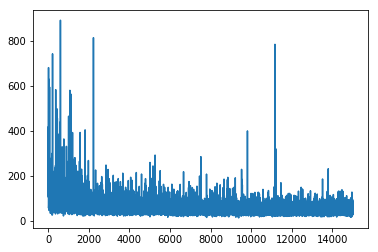

In [114]:
plt.figure()
plt.plot(losses)
plt.show()

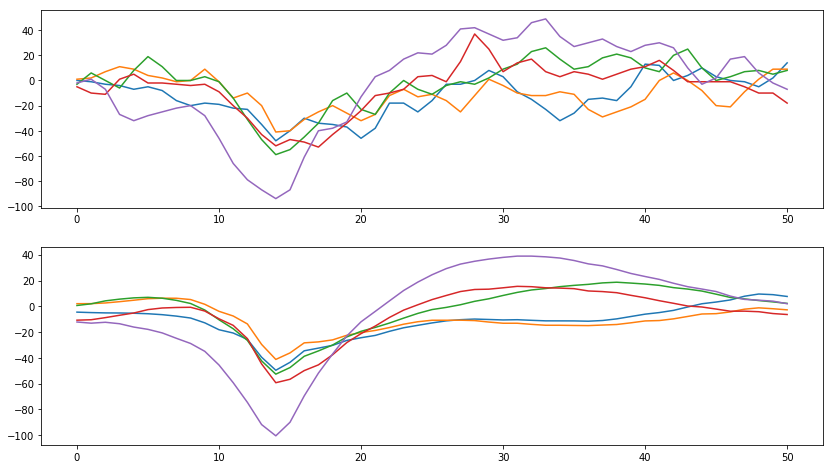

In [115]:
plt.figure(figsize=(14,8))

# n = [1, 30, 45, 50, 65]
n = [3490, 1098, 8707, 6709, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o = model.forward_numpy(data)
    o = (o.data).cpu().numpy()
    plt.subplot(211)
    plt.plot(electrode_data_test[i, :])
    plt.subplot(212)
    plt.plot(o)
plt.show()

## Using GANs for super-resolution

### Designing the GAN

In [181]:
class generator(nn.Module):
    def __init__(self, input_size):
        super(generator, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_size, 512),
                                     nn.ELU(),
                                     nn.Linear(512, 256),
                                     nn.ELU(),
                                     nn.Linear(256, 128),
                                     nn.ELU(),
                                     nn.Dropout(p=0.1),
                                     nn.Linear(128, 64),
                                     nn.ELU(),
                                     nn.Linear(64, 32),
                                     nn.ELU(),
                                     nn.Linear(32, 16),
                                     nn.ELU(),
                                     nn.Linear(16, 8))
        self.decoder = nn.Sequential(nn.Linear(8, 16),
                                     nn.ELU(),
                                     nn.Linear(16, 32),
                                     nn.ELU(),
                                     nn.Linear(32, 64),
                                     nn.ELU(),
                                     nn.Dropout(p=0.1),
                                     nn.Linear(64, 128),
                                     nn.ELU(),
                                     nn.Linear(128, 256),
                                     nn.ELU(),
                                     nn.Linear(256, 512),
                                     nn.ELU(),
                                     nn.Linear(512, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [182]:
class discriminator(nn.Module):
    def __init__(self, input_size):
        super(discriminator, self).__init__()
        self.detect = nn.Sequential(nn.Linear(input_size, 32),
                                    nn.ELU(),
                                    nn.Linear(32, 16),
                                    nn.ELU(),
                                    nn.Linear(16, 4),
                                    nn.ELU(),
                                    nn.Linear(4, 1),
                                    nn.Sigmoid())
    def forward(self, x):
        out = self.detect(x)
        return out

In [187]:
def train_gan(disc, gen, input_data, d_criterion, g_criterion, d_optimizer, g_optimizer, epoch_range,  
              batch_size_d, batch_size_g):
    for num_epoch in range(epoch_range):
        d_selected = random.sample(range(0, input_data.shape[0]), batch_size_d)

        for feats in d_selected:
            #---------Training the discriminator on real data------#
            real_data = input_data[feats, :]
            real_data = torch.from_numpy(real_data).float().cuda()
            #---------FORWARD------------#
            real_decision = disc.forward(real_data)
            real_decision = torch.tensor(real_decision).float().cuda()
            real_loss = d_criterion(real_decision, Variable(torch.ones(1)).cuda())
            #---------BACKWARD------------#
            real_loss.backward()
            
            #---------Training the discriminator on fake data------#
            enc, fake_data = gen.forward(real_data)
            fake_data = torch.tensor(fake_data).float().cuda()
            #---------FORWARD------------#
            fake_decision = disc.forward(fake_data)
            fake_decision = torch.tensor(fake_decision).float().cuda()
            fake_loss = d_criterion(fake_decision, Variable(torch.zeros(1)).cuda())
            #---------BACKWARD------------#
            fake_loss.backward()
            
            d_optimizer.zero_grad()            
            d_optimizer.step()
        
        g_selected = random.sample(range(0, input_data.shape[0]), batch_size_g)
        
        for feats in g_selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = gen.forward(x)
            out = torch.tensor(out).float().cuda()
            g_loss = g_criterion(out, x)
            #---------BACKWARD------------#
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
        print('epoch [{}/{}], disc_real_loss:{:.4f}, disc_fake_loss:{:.4f}, gen_loss:{:.4f}'.format(num_epoch + 1, 
                                                    epoch_range, real_loss.data[0], fake_loss.data[0], g_loss.data[0]))
    return out

In [188]:
def init_gan_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

In [190]:
epoch_range = 60
batch_size_d = 300
batch_size_g = 100
g_learning_rate = 0.0001
d_learning_rate = 0.000001

# Defining the models
gen = generator(length).cuda()
disc = discriminator(length).cuda()

# Initialising the weights
gen.apply(init_gan_weights)
disc.apply(init_gan_weights)

# Setting up the loss criteria
g_criterion = nn.MSELoss()
d_criterion = nn.BCELoss()

# Setting up the Optimizer (Using Adam here)
g_optimizer = torch.optim.Adam(
    gen.parameters(), lr=g_learning_rate, weight_decay=0.001)
d_optimizer = torch.optim.Adam(
    disc.parameters(), lr=d_learning_rate, weight_decay=0.001)

out = train_gan(disc, gen, electrode_data_train, d_criterion, g_criterion, 
                             d_optimizer, g_optimizer, epoch_range, batch_size_d, batch_size_g)

epoch [1/60], disc_real_loss:2.2571, disc_fake_loss:0.8567, gen_loss:160.5221
epoch [2/60], disc_real_loss:1.5821, disc_fake_loss:3.1085, gen_loss:478.0204
epoch [3/60], disc_real_loss:0.0000, disc_fake_loss:1.5479, gen_loss:183.4545
epoch [4/60], disc_real_loss:6.0792, disc_fake_loss:1.3660, gen_loss:302.0658
epoch [5/60], disc_real_loss:0.0000, disc_fake_loss:3.4616, gen_loss:129.2658
epoch [6/60], disc_real_loss:0.0000, disc_fake_loss:9.1333, gen_loss:191.2411
epoch [7/60], disc_real_loss:0.0000, disc_fake_loss:4.4439, gen_loss:1472.2577
epoch [8/60], disc_real_loss:0.0000, disc_fake_loss:27.6310, gen_loss:205.0259
epoch [9/60], disc_real_loss:0.0000, disc_fake_loss:27.6310, gen_loss:112.5483
epoch [10/60], disc_real_loss:0.0000, disc_fake_loss:8.0388, gen_loss:196.4167
epoch [11/60], disc_real_loss:0.0002, disc_fake_loss:3.7045, gen_loss:133.5545
epoch [12/60], disc_real_loss:0.0000, disc_fake_loss:10.7059, gen_loss:76.4254
epoch [13/60], disc_real_loss:0.0207, disc_fake_loss:12.03

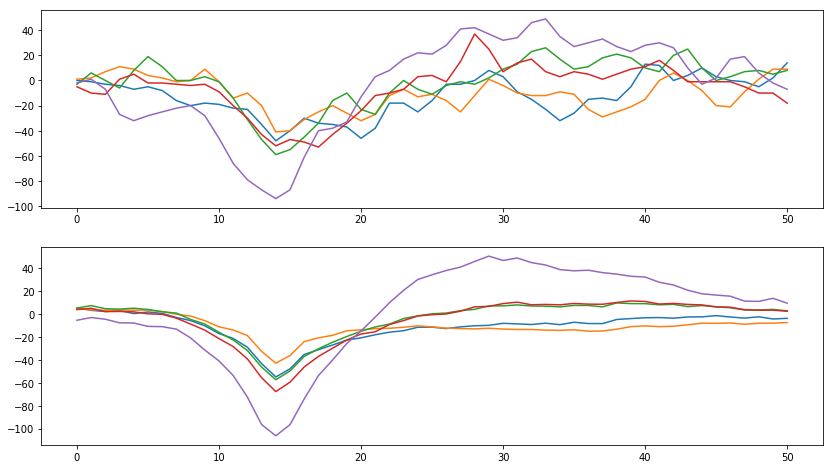

In [191]:
plt.figure(figsize=(14,8))

# n = [1, 30, 45, 50, 65]
n = [3490, 1098, 8707, 6709, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o = gen.forward(data)
    o = (o.data).cpu().numpy()
    plt.subplot(211)
    plt.plot(electrode_data_test[i, :])
    plt.subplot(212)
    plt.plot(o)
plt.show()